In [69]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 6 2021

@authors: R. van Hoof & A. Lozano
"""

# test changes Antonio :D

# %matplotlib inline


RIGHT HEMISPHERE V1 IS THE LEFT HEMISPHERE ACTUALLY. WE MAY BE USING THE WRONG ALPHA AND BETA CONSTRAINTS THEN

THE RESULTS LOOK WEIRD

WE SHOULD ADD TRANSLATION IN X AND Y WHICH WILL BE DEFINED AS ORTHOGONAL TO Z (DEPTH)





'\nCreated on Wed May 6 2021\n\n@authors: R. van Hoof & A. Lozano\n'

In [70]:
import time
import os.path
import pickle # needed to store the results
from copy import deepcopy
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score as MI
from skopt.utils import use_named_args
from skopt.space import Integer, Categorical, Real
from skopt.utils import cook_initial_point_generator
from skopt import gp_minimize
import trimesh # needed for convex hull

########################
### Custom functions ###
########################
from ninimplant import pol2cart, get_xyz # matrix rotation/translation ect
from lossfunc import DC, KL, get_yield, hellinger_distance, get_yield_fast
from electphos import create_grid, reposition_grid, implant_grid, normalized_uv, get_phosphenes, get_phosphenes_fast, prf_to_phos, gen_dummy_phos, get_cortical_magnification, cortical_spread
import visualsectors as gvs

# ignore "True-divide" warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [71]:
##########
## INIT ##
##########

# datafolder = '/path/to/data/'
# outputfolder = '/path/to/data/'
# datafolder = 'F:/Rick/Surfdrive_BACKUP/Data/NESTOR/HCP/subjects/'
datafolder = r'C:/Users/Lozano/Desktop/NIN/bayesian_optimization_paper/data/subjects/'
outputfolder =  r'C:/Users/Lozano/Desktop/NIN/bayesian_optimization_paper/data/output/'

datafolder= r'C:\Users\Lozano\Desktop\NIN\bayesian_optimization_paper\vimplant_review_repo\vimplant_review\data\demo_subject\subjects\\'
outputfolder = r'C:\Users\Lozano\Desktop\NIN\bayesian_optimization_paper\vimplant_review_repo\vimplant_review\data\output\\'

# determine range of parameters used in optimization
dim1 = Integer(name='alpha', low=-90, high=90) # visual degrees 
dim2 = Integer(name='beta', low=-15, high=110) # visual degrees - -15 is probably lowest possible angle, otherwise other hem is in the way if hem = RH -> low = -110, high = 15
dim3 = Integer(name='offset_from_base', low=0, high=40) # in mm
dim4 = Integer(name='shank_length', low=10, high=40) # mm
dimensions = [dim1, dim2, dim3, dim4]

#num_calls = 150
num_calls = 25 # this is the minimum
x0 = (0,0,20,25) # initial values for the four dimensions
num_initial_points = 10
dc_percentile = 50
n_contactpoints_shank = 10
spacing_along_xy = 1
WINDOWSIZE = 100

# lists of loss term combinations to loop through
    # Dice Coefficient (1, 0, 0)
    # Yield (0, 1, 0)
    # Hellinger Distance (0, 0, 1)
loss_comb = ([(1, 0.1, 1)]) # weights for loss terms
loss_names = (['dice-yield-HD']) # substring in output filename


# lists of target maps to loop through
# fwhm: Full-Width Half-Maximum of the gaussian
# shape: The shape of the target array.
# centre: Coordinates of the center of the circular sector.
# radiusLow and radiusHigh: Inner and outer radius of the sector (defining a circular ring section).
# angle_range: Tuple with start and stop angles (in degrees), defining the angular span of the sector.
#targ_comb = ([gvs.upper_sector(windowsize=WINDOWSIZE, fwhm=800, radiusLow=0, radiusHigh=500, plotting=False), 
#              gvs.lower_sector(windowsize=WINDOWSIZE, fwhm=800, radiusLow=0, radiusHigh=500, plotting=False),
#              gvs.inner_ring(windowsize=WINDOWSIZE, fwhm=400, radiusLow=0, radiusHigh=250, plotting=False),
#              gvs.complete_gauss(windowsize=1000, fwhm=1200, radiusLow=0, radiusHigh=500, center=None, plotting=False)])
#targ_names = (['targ-upper', 'targ-lower', 'targ-inner', 'targ-full'])

# lets start with just one target
#targ_comb = ([gvs.upper_sector(windowsize=WINDOWSIZE, fwhm=800, radiusLow=0, radiusHigh=500, plotting=False)])
#targ_names = (['targ-upper'])



######################
# Define window size
WINDOWSIZE = 1000

# Parameterize based on WINDOWSIZE
fwhm_large = int(WINDOWSIZE * 0.8)  # 80% of WINDOWSIZE
fwhm_small = int(WINDOWSIZE * 0.4)  # 40% of WINDOWSIZE
radius_high_large = int(WINDOWSIZE * 0.5)  # 50% of WINDOWSIZE
radius_high_small = int(WINDOWSIZE * 0.25) # 25% of WINDOWSIZE
radius_low = 0  # keeping radiusLow at 0

# Loss term combinations
loss_comb = ([(1, 0.1, 1)])  # weights for loss terms
loss_names = (['dice-yield-HD'])  # substring in output filename

# Target maps with parameterized values
targ_comb = ([gvs.upper_sector(windowsize=WINDOWSIZE, fwhm=fwhm_large, radiusLow=radius_low, radiusHigh=radius_high_large, plotting=False), 
              gvs.lower_sector(windowsize=WINDOWSIZE, fwhm=fwhm_large, radiusLow=radius_low, radiusHigh=radius_high_large, plotting=False),
              gvs.inner_ring(windowsize=WINDOWSIZE, fwhm=fwhm_small, radiusLow=radius_low, radiusHigh=radius_high_small, plotting=False),
              gvs.complete_gauss(windowsize=WINDOWSIZE, fwhm=int(WINDOWSIZE * 1.2), radiusLow=radius_low, radiusHigh=radius_high_large, center=None, plotting=False)])

targ_names = (['targ-upper', 'targ-lower', 'targ-inner', 'targ-full'])

# Optionally, if you want to start with just one target:
targ_comb = ([gvs.upper_sector(windowsize=WINDOWSIZE, fwhm=fwhm_large, radiusLow=radius_low, radiusHigh=radius_high_large, plotting=False)])
targ_names = (['targ-upper'])


# Optionally, if you want to start with just one target:
targ_comb = ([gvs.inner_ring(windowsize=WINDOWSIZE, fwhm=fwhm_small, radiusLow=radius_low, radiusHigh=radius_high_small, plotting=False)])
targ_names = (['targ-inner'])

# Optionally, if you want to start with just one target:
targ_comb = ([gvs.complete_gauss(windowsize=WINDOWSIZE, fwhm=int(WINDOWSIZE * 1.2), radiusLow=radius_low, radiusHigh=radius_high_large, center=None, plotting=False)])
targ_names = (['targ-full'])

#############







# constants pRF model
cort_mag_model = 'wedge-dipole' # which cortex model to use for the cortical magnification
view_angle = 90 #in degrees of visual angle
amp = 100 #stimulation amplitude in micro-amp (higher stimulation -> more tissue activated)

# INIT Bayes
amax = 1
bmax = 1
cmax = 1000
N=5
delta=0.2
thresh=0.05

# subjects to include
subj_list = [118225, 144226, 162935, 176542, 187345, 200614, 251833, 389357, 547046, 671855, 789373, 901139,  
100610, 125525, 145834, 164131, 177140, 191033, 201515, 257845, 393247, 550439, 680957, 814649, 901442, 
102311, 126426, 146129, 164636, 177645, 191336, 203418, 263436, 395756, 552241, 690152, 818859, 905147, 
102816, 128935, 146432, 165436, 177746, 191841, 204521, 283543, 397760, 562345, 706040, 825048, 910241, 
104416, 130114, 146735, 167036, 178142, 192439, 205220, 318637, 401422, 572045, 724446, 826353, 926862, 
105923, 130518, 146937, 167440, 178243, 192641, 209228, 320826, 406836, 573249, 725751, 833249, 927359, 
108323, 131217, 148133, 169040, 178647, 193845, 212419, 330324, 412528, 581450, 732243, 859671, 942658, 
109123, 131722, 150423, 169343, 180533, 195041, 214019, 346137, 429040, 585256, 751550, 861456, 943862, 
111312, 132118, 155938, 169444, 181232, 196144, 214524, 352738, 436845, 601127, 757764, 871762, 951457, 
111514, 134627, 156334, 169747, 181636, 197348, 221319, 360030, 463040, 617748, 765864, 872764, 958976, 
114823, 134829, 157336, 171633, 182436, 198653, 233326, 365343, 467351, 627549, 770352, 878776, 966975, 
115017, 135124, 158035, 172130, 182739, 199655, 239136, 380036, 525541, 638049, 771354, 878877, 971160, 
115825, 137128, 158136, 173334, 185442, 200210, 246133, 381038, 536647, 644246, 782561, 898176, 973770, 
116726, 140117, 159239, 175237, 186949, 200311, 249947, 385046, 541943, 654552, 783462, 899885, 995174, 'fsaverage']

subj_list = [100206]
subj_list = [100610]

In [72]:
targ_comb[0].shape

(1000, 1000)

In [73]:
################################################
## Functions related to Bayesian optimization ##
################################################

def custom_stopper(res, N=5, delta=0.2, thresh=0.05):
    '''
    Returns True (stops the optimization) when 
    the difference between best and worst of the best N are below delta AND the best is below thresh
    
    N = last number of cost values to track
    delta = ratio best and worst
    
    '''
    
    if len(res.func_vals) >= N:
        func_vals = np.sort(res.func_vals)
        worst = func_vals[N - 1]
        best = func_vals[0]
        
        return (abs((best - worst)/worst) < delta) & (best < thresh)
    else:
        return None

@use_named_args(dimensions=dimensions)
def f(alpha, beta, offset_from_base, shank_length):
    """
    This function encapsulates the electrode placement procedure and returns the cost value by 
    comparing the resulting phosphene map with the target map.    
    * First it creats a grid based on the four parameters. 
    * Then, it virtually implants the grid within the brain.
    * Phosphenes are generated based on the grid's contact points within the brain, 
      and their sizes are determined using cortical magnification and spread values. 
    * These phosphenes are converted into a 2D image representation. 
    * The cost function then computes the dice coefficient and yield, and calculates the Hellinger 
      distance between the generated image and a target density. 
    * The resulting combined cost is a combination of these factors, 
      with penalties applied if the grid is invalid. 
    * The function also handles cases of invalid values and prints diagnostic information. 
    * Ultimately, the function returns the calculated cost used by the bayesopt algorithm.
    """
    
    penalty = 0.25
    new_angle = (float(alpha), float(beta), 0)    
    
    # Start time profiling
    start_time = time.time()
    
    # create grid
    step_start = time.time()
    orig_grid = create_grid(start_location, shank_length, n_contactpoints_shank, spacing_along_xy, offset_from_origin=0)
    print("Grid creation time:", time.time() - step_start)
    
    # implanting grid
    #step_start = time.time()
    #_, contacts_xyz_moved, _, _, _, _, _, _, grid_valid = implant_grid(gm_mask, orig_grid, start_location, new_angle, offset_from_base)
    #print("Grid implantation time:", time.time() - step_start)
    
    
    # Run and time the original implant_grid function
    step_start = time.time()
    _, contacts_xyz_moved, _, _, _, _, _, _, grid_valid = implant_grid(gm_mask, orig_grid, start_location, new_angle, offset_from_base)
    original_time = time.time() - step_start
    print("Original Grid implantation time:", original_time)
 
    # get angle, ecc and rfsize for contactpoints
    step_start = time.time()
    phosphenes = get_phosphenes_fast(contacts_xyz_moved, good_coords, polar_map, ecc_map, sigma_map)
    phosphenes_V1 = get_phosphenes_fast(contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)
    phosphenes_V2 = get_phosphenes_fast(contacts_xyz_moved, good_coords_V2, polar_map, ecc_map, sigma_map)   
    phosphenes_V3 = get_phosphenes_fast(contacts_xyz_moved, good_coords_V3, polar_map, ecc_map, sigma_map)
    print("Phosphene generation time:", time.time() - step_start)

    # inverse cortical magnification and spread calculations
    step_start = time.time()
    M = 1 / get_cortical_magnification(phosphenes_V1[:,1], cort_mag_model) 
    spread = cortical_spread(amp)
    sizes = spread * M
    sigmas = sizes / 2
    phosphenes_V1[:,2] = sigmas
    print("Cortical magnification and spread time:", time.time() - step_start)

    # generate phosphene map
    step_start = time.time()
    phospheneMap = np.zeros((WINDOWSIZE, WINDOWSIZE), 'float32') 
    phospheneMap = prf_to_phos(phospheneMap, phosphenes_V1, view_angle=view_angle, phSizeScale=1)
    phospheneMap /= phospheneMap.max()
    phospheneMap /= phospheneMap.sum()
    print("Phosphene map generation time:", time.time() - step_start)

    # compute dice coefficient
    step_start = time.time()
    bin_thresh = np.percentile(target_density, dc_percentile)
    dice, im1, im2 = DC(target_density, phospheneMap, bin_thresh)
    par1 = 1.0 - (a * dice)
    print("Dice coefficient computation time:", time.time() - step_start)

    # Optimized get_yield_fast
    step_start = time.time()
    grid_yield = get_yield_fast(contacts_xyz_moved, good_coords)
    par2= 1.0 - (b * grid_yield)
    fast_yield_time = time.time() - step_start
    
    # Print comparison results
    print(f"Optimized get_yield_fast result: {grid_yield}, Time: {fast_yield_time:.6f} seconds")

    # compute Hellinger distance
    step_start = time.time()
    hell_d = hellinger_distance(phospheneMap.flatten(), target_density.flatten())
    if np.isnan(hell_d) or np.isinf(hell_d):
        par3 = 1
        print('Hellinger distance is nan or inf')
    else:
        par3 = c * hell_d
    print("Hellinger distance computation time:", time.time() - step_start)

    # validations and cost combination
    step_start = time.time()
    if np.isnan(phospheneMap).any() or np.sum(phospheneMap) == 0:
        par1 = 1
        print('Phosphene map is nan or 0')
    if not grid_valid:
        cost = par1 + penalty + par2 + penalty + par3 + penalty
    else:
        cost = par1 + par2 + par3
    if np.isnan(cost) or np.isinf(cost):
        cost = 3
    print("Cost combination and validation time:", time.time() - step_start)

    # Final output and total time
    print("Total function time:", time.time() - start_time)
    print('    ', "{:.2f}".format(cost), "{:.2f}".format(dice), "{:.2f}".format(grid_yield), "{:.2f}".format(par3), grid_valid)
    
    return cost

@use_named_args(dimensions=dimensions)
def f(alpha, beta, offset_from_base, shank_length):
    """
    This function encapsulates the electrode placement procedure and returns the cost value by 
    comparing the resulting phosphene map with the target map.    
    * First it creates a grid based on the four parameters. 
    * Then, it virtually implants the grid within the brain.
    * Phosphenes are generated based on the grid's contact points within the brain, 
      and their sizes are determined using cortical magnification and spread values. 
    * These phosphenes are converted into a 2D image representation. 
    * The cost function then computes the dice coefficient and yield, and calculates the Hellinger 
      distance between the generated image and a target density. 
    * The resulting combined cost is a combination of these factors, 
      with penalties applied if the grid is invalid. 
    * The function also handles cases of invalid values.
    * Ultimately, the function returns the calculated cost used by the bayesopt algorithm.
    """
    
    penalty = 0.25
    new_angle = (float(alpha), float(beta), 0)    
    
    # Start time profiling
    start_time = time.time()
    
    # create grid
    step_start = time.time()
    orig_grid = create_grid(start_location, shank_length, n_contactpoints_shank, spacing_along_xy, offset_from_origin=0)
    # print("Grid creation time:", time.time() - step_start)
    
    # implanting grid
    step_start = time.time()
    _, contacts_xyz_moved, _, _, _, _, _, _, grid_valid = implant_grid(gm_mask, orig_grid, start_location, new_angle, offset_from_base)
    original_time = time.time() - step_start
    # print("Original Grid implantation time:", original_time)
 
    # get angle, ecc and rfsize for contactpoints
    step_start = time.time()
    phosphenes = get_phosphenes_fast(contacts_xyz_moved, good_coords, polar_map, ecc_map, sigma_map)
    phosphenes_V1 = get_phosphenes_fast(contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)
    phosphenes_V2 = get_phosphenes_fast(contacts_xyz_moved, good_coords_V2, polar_map, ecc_map, sigma_map)   
    phosphenes_V3 = get_phosphenes_fast(contacts_xyz_moved, good_coords_V3, polar_map, ecc_map, sigma_map)
    # print("Phosphene generation time:", time.time() - step_start)

    # inverse cortical magnification and spread calculations
    step_start = time.time()
    M = 1 / get_cortical_magnification(phosphenes_V1[:,1], cort_mag_model) 
    spread = cortical_spread(amp)
    sizes = spread * M
    sigmas = sizes / 2
    phosphenes_V1[:,2] = sigmas
    # print("Cortical magnification and spread time:", time.time() - step_start)

    # generate phosphene map
    step_start = time.time()
    phospheneMap = np.zeros((WINDOWSIZE, WINDOWSIZE), 'float32') 
    phospheneMap = prf_to_phos(phospheneMap, phosphenes_V1, view_angle=view_angle, phSizeScale=1)
    phospheneMap /= phospheneMap.max()
    phospheneMap /= phospheneMap.sum()
    # print("Phosphene map generation time:", time.time() - step_start)

    # compute dice coefficient
    step_start = time.time()
    bin_thresh = np.percentile(target_density, dc_percentile)
    dice, im1, im2 = DC(target_density, phospheneMap, bin_thresh)
    par1 = 1.0 - (a * dice)
    # print("Dice coefficient computation time:", time.time() - step_start)

    # Optimized get_yield_fast
    step_start = time.time()
    grid_yield = get_yield_fast(contacts_xyz_moved, good_coords)
    par2 = 1.0 - (b * grid_yield)
    fast_yield_time = time.time() - step_start
    
    # print(f"Optimized get_yield_fast result: {grid_yield}, Time: {fast_yield_time:.6f} seconds")

    # compute Hellinger distance
    step_start = time.time()
    hell_d = hellinger_distance(phospheneMap.flatten(), target_density.flatten())
    if np.isnan(hell_d) or np.isinf(hell_d):
        par3 = 1
        # print('Hellinger distance is nan or inf')
    else:
        par3 = c * hell_d
    # print("Hellinger distance computation time:", time.time() - step_start)

    # validations and cost combination
    step_start = time.time()
    if np.isnan(phospheneMap).any() or np.sum(phospheneMap) == 0:
        par1 = 1
        # print('Phosphene map is nan or 0')
    if not grid_valid:
        cost = par1 + penalty + par2 + penalty + par3 + penalty
    else:
        cost = par1 + par2 + par3
    if np.isnan(cost) or np.isinf(cost):
        cost = 3
    # print("Cost combination and validation time:", time.time() - step_start)

    # Final output and total time
    # print("Total function time:", time.time() - start_time)
    # print('    ', "{:.2f}".format(cost), "{:.2f}".format(dice), "{:.2f}".format(grid_yield), "{:.2f}".format(par3), grid_valid)
    
    return cost

def f_manual(alpha, beta, offset_from_base, shank_length, good_coords, good_coords_V1, good_coords_V2, good_coords_V3, target_density):
    '''
    Copy from f, to obtain phosphene map and contact points for the optimized parameters. Used to visualize results.

    also returns coords used ect.
    '''
    
    penalty = 0.25
    new_angle = (float(alpha), float(beta), 0)
    
    # create grid
    orig_grid = create_grid(start_location, shank_length, n_contactpoints_shank, spacing_along_xy, offset_from_origin=0)

    # implanting grid with profiled implant_grid function
    ref_contacts_xyz, contacts_xyz_moved, refline, refline_moved, projection, ref_orig, ray_visualize, new_location, grid_valid = implant_grid(gm_mask, orig_grid, start_location, new_angle, offset_from_base)

    # get angle, ecc, and rfsize for contact points in each ROI
    phosphenes = get_phosphenes_fast(contacts_xyz_moved, good_coords, polar_map, ecc_map, sigma_map)
    phosphenes_V1 = get_phosphenes_fast(contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)
    phosphenes_V2 = get_phosphenes_fast(contacts_xyz_moved, good_coords_V2, polar_map, ecc_map, sigma_map)
    phosphenes_V3 = get_phosphenes_fast(contacts_xyz_moved, good_coords_V3, polar_map, ecc_map, sigma_map)
    
    # inverse cortical magnification and spread calculations
    M = 1 / get_cortical_magnification(phosphenes_V1[:,1], cort_mag_model)
    spread = cortical_spread(amp)
    sizes = spread * M
    sigmas = sizes / 2
    phosphenes_V1[:,2] = sigmas

    # generate map using Gaussians, transforming phosphenes to a 2D image
    phospheneMap = np.zeros((WINDOWSIZE, WINDOWSIZE), 'float32')
    phospheneMap = prf_to_phos(phospheneMap, phosphenes_V1, view_angle=view_angle, phSizeScale=1)
    phospheneMap /= phospheneMap.max()
    phospheneMap /= phospheneMap.sum()
    # print(view_angle)
    
    # set bin threshold to determine size target
    bin_thresh = np.percentile(target_density, dc_percentile)

    # compute dice coefficient and invert cost for maximization
    dice, im1, im2 = DC(target_density, phospheneMap, bin_thresh)
    par1 = 1.0 - (a * dice)

    # compute yield with optimized function
    grid_yield = get_yield_fast(contacts_xyz_moved, good_coords)
    par2 = 1.0 - (b * grid_yield)  
    
    # normalize target density to the same range as phospheneMap
    target_density /= target_density.max()
    target_density /= target_density.sum()        
    
    # compute Hellinger distance and validate
    hell_d = hellinger_distance(phospheneMap.flatten(), target_density.flatten())
    
    if np.isnan(phospheneMap).any() or np.sum(phospheneMap) == 0:
        par1 = 1
        # print('Phosphene map is nan or 0')
    
    if np.isnan(hell_d) or np.isinf(hell_d):
        par3 = 1
        # print('Hellinger distance is nan or inf')
    else:
        par3 = c * hell_d
    
    # combine cost functions
    cost = par1 + par2 + par3

    # apply penalty if grid is invalid
    if not grid_valid:
        cost = par1 + penalty + par2 + penalty + par3 + penalty
    
    # validate cost to ensure no invalid values
    if np.isnan(cost) or np.isinf(cost):
        cost = 3
    
    return grid_valid, dice, hell_d, grid_yield, phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3, contacts_xyz_moved, phospheneMap


number of subjects: 1
Target density setup time: 0.011240720748901367
Map loading time: 1.2153549194335938
Valid voxel computation time: 0.22484493255615234
Hemisphere filtering time: 0.7311182022094727
Label extraction time: 1.0560503005981445
Median computation time: 0.0
Optimization time: 15.463989734649658
subject  100610   LH
best alpha: 10
best beta: -15
best offset_from_base: 32
best shank_length: 16
best dice, yield, KL:  0.5084883945671463 0.48 0.7653854150073064


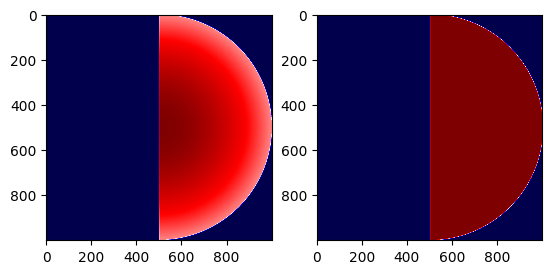

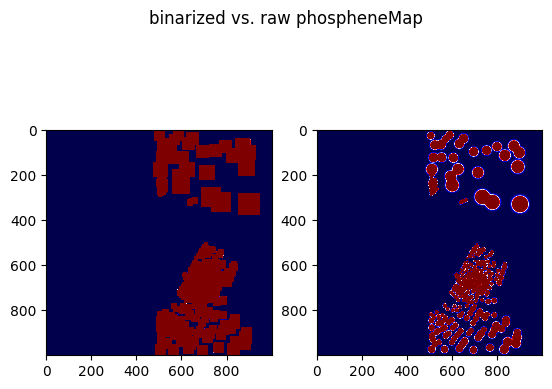

    max phospheneMap:  8.703283e-05
Save time: 0.0
Optimization loop time: 16.526959657669067
Loop time for target: 22.900168895721436
Total time: 22.903168439865112


In [79]:
import time

###################
## Main Sim Loop ##
###################

override_results = True

# set file names
fname_ang = 'inferred_angle.mgz'
fname_ecc = 'inferred_eccen.mgz'
fname_sigma = 'inferred_sigma.mgz'
fname_anat = 'T1.mgz'
fname_aparc = 'aparc+aseg.mgz'
fname_label = 'inferred_varea.mgz'

start_time = time.time()
print('number of subjects: ' + str(len(subj_list)))

# set beta angle constraints according to hemisphere
dim2_lh = Integer(name='beta', low=-15, high=110)
dim2_rh = Integer(name='beta', low=-110, high=15)

# loop through phosphene target maps and combinations of loss terms
for target_density, ftarget in zip(targ_comb, targ_names):
    loop_start = time.time()
    for (a, b, c), floss in zip(loss_comb, loss_names):
        # Timing target density setup
        step_start = time.time()
        target_density /= target_density.max()
        target_density /= target_density.sum()
        bin_thresh = np.percentile(target_density, dc_percentile)
        target_density_bin = (target_density > bin_thresh).astype(bool)
        print("Target density setup time:", time.time() - step_start)
        
        fig, (ax1, ax2) = plt.subplots(1, 2)
        plt.subplot(1,2,1).imshow(target_density, cmap = 'seismic')
        plt.subplot(1,2,2).imshow(target_density_bin, cmap = 'seismic')

        for s in subj_list:
            data_dir = datafolder + str(s)+ '/T1w/' + str(s) + '/mri/'            
            if s == 'fsaverage':
                data_dir = datafolder + str(s) + '/mri/'

            # Loading maps and timing
            load_start = time.time()
            ang_img = nib.load(data_dir + fname_ang)
            polar_map = ang_img.get_fdata()
            ecc_img = nib.load(data_dir + fname_ecc)
            ecc_map = ecc_img.get_fdata()
            sigma_img = nib.load(data_dir + fname_sigma)
            sigma_map = sigma_img.get_fdata()                
            aparc_img = nib.load(data_dir + fname_aparc)
            aparc_roi = aparc_img.get_fdata()
            label_img = nib.load(data_dir + fname_label)
            label_map = label_img.get_fdata()
            print("Map loading time:", time.time() - load_start)

            # Compute valid voxels
            step_start = time.time()
            dot = (ecc_map * polar_map)
            good_coords = np.asarray(np.where(dot != 0.0))
            print("Valid voxel computation time:", time.time() - step_start)

            # Hemisphere filtering
            step_start = time.time()
            cs_coords_rh = np.where(aparc_roi == 1021)
            cs_coords_lh = np.where(aparc_roi == 2021)
            gm_coords_rh = np.where((aparc_roi >= 1000) & (aparc_roi < 2000))
            gm_coords_lh = np.where(aparc_roi > 2000)
            xl, yl, zl = get_xyz(gm_coords_lh)
            xr, yr, zr = get_xyz(gm_coords_rh)
            GM_LH = np.array([xl, yl, zl]).T
            GM_RH = np.array([xr, yr, zr]).T
            print("Hemisphere filtering time:", time.time() - step_start)

            # Extract labels
            step_start = time.time()
            V1_coords_rh = np.asarray(np.where(label_map == 1))
            V1_coords_lh = np.asarray(np.where(label_map == 1))
            V2_coords_rh = np.asarray(np.where(label_map == 2))
            V2_coords_lh = np.asarray(np.where(label_map == 2))
            V3_coords_rh = np.asarray(np.where(label_map == 3))
            V3_coords_lh = np.asarray(np.where(label_map == 3))
            print("Label extraction time:", time.time() - step_start)

            # divide V1 coords per hemisphere
            good_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(good_coords).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            good_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(good_coords).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T
            V1_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(V1_coords_lh).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            V1_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(V1_coords_rh).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T
            V2_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(V2_coords_lh).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            V2_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(V2_coords_rh).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T
            V3_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(V3_coords_lh).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            V3_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(V3_coords_rh).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T           
            
            # Compute median of left and right calcarine sulci
            step_start = time.time()
            median_lh = [np.median(cs_coords_lh[0][:]), np.median(cs_coords_lh[1][:]), np.median(cs_coords_lh[2][:])]
            median_rh = [np.median(cs_coords_rh[0][:]), np.median(cs_coords_rh[1][:]), np.median(cs_coords_rh[2][:])]
            print("Median computation time:", time.time() - step_start)

            # Optimization loop per hemisphere
            opt_start = time.time()
            #for gm_mask, hem, start_location, good_coords, good_coords_V1, good_coords_V2, good_coords_V3, dim2 in zip(
            #    [GM_LH, GM_RH], ['LH', 'RH'], [median_lh, median_rh], 
            #    [good_coords_lh, good_coords_rh], [V1_coords_lh, V1_coords_rh], 
            #    [V2_coords_lh, V2_coords_rh], [V3_coords_lh, V3_coords_rh], [dim2_lh, dim2_rh]
            #):    

            
            for gm_mask, hem, start_location, good_coords, good_coords_V1, good_coords_V2, good_coords_V3, dim2 in zip(
                    [GM_LH],            # Only left hemisphere mask
                    ['LH'],             # Only left hemisphere name
                    [median_lh],        # Only left hemisphere start location
                    [good_coords_lh],   # Only left hemisphere good coordinates
                    [V1_coords_lh],     # Only left hemisphere V1 coordinates
                    [V2_coords_lh],     # Only left hemisphere V2 coordinates
                    [V3_coords_lh],     # Only left hemisphere V3 coordinates
                    [dim2_lh]           # Only left hemisphere dimension
                ):


                
                # Check if already processed
                step_start = time.time()
                data_id = f"{s}_{hem}_V1_n1000_1x10_{floss}_{str(thresh)}_{ftarget}"
                #fname = '/mnt/c/DATA/NESTOR/HCP/simresults/' + data_id + 'it.pkl'
                fname = r'C:\Users\Lozano\Desktop\NIN\bayesian_optimization_paper\vimplant_review_repo\vimplant_review\data\simresults' + '\\' + data_id + 'it.pkl'

                if not override_results:
                    if os.path.exists(fname):
                        print(f"{s} {hem} {ftarget} {floss} already processed.")
                        continue

                # Initialize optimizer
                dimensions = [dim1, dim2, dim3, dim4]
                lhs2 = cook_initial_point_generator("lhs", criterion="maximin")
                
                # Perform optimization and timing
                optimize_start = time.time()
                res = gp_minimize(f, x0=x0, dimensions=dimensions, n_jobs=-1, n_calls=num_calls,
                                  n_initial_points=num_initial_points, initial_point_generator=lhs2,
                                  callback=[custom_stopper])
                print("Optimization time:", time.time() - optimize_start)
                
                # print results
                print('subject ', s, ' ', hem)
                print('best alpha:', res.x[0])
                print('best beta:',res.x[1])
                print('best offset_from_base:', res.x[2])
                print('best shank_length:',res.x[3])
                grid_valid, dice, hell_d, grid_yield, phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3, contacts_xyz_moved, phospheneMap = f_manual(res.x[0], res.x[1],res.x[2], res.x[3], good_coords, good_coords_V1, good_coords_V2, good_coords_V3, target_density)
                print('best dice, yield, KL: ', dice, grid_yield, hell_d)

                # show resulting binary phosphene map (reflects dice coefficient)
                bin_thresh=np.percentile(phospheneMap, dc_percentile) #np.min(target_density) # bin_thesh determines size target
                phospheneMap_bin = (phospheneMap > bin_thresh).astype(bool)
                fig, (ax1, ax2) = plt.subplots(1, 2)
                fig.suptitle('binarized vs. raw phospheneMap')
                plt.subplot(1,2,1).imshow(phospheneMap_bin, cmap = 'seismic', vmin=0, vmax=np.max(phospheneMap)/100)
                plt.subplot(1,2,2).imshow(phospheneMap, cmap = 'seismic', vmin=0, vmax=np.max(phospheneMap)/100)
                plt.show()
                print('    max phospheneMap: ', np.max(phospheneMap))        

                # Save results
                save_start = time.time()
                with open(fname, 'wb') as file:
                    pickle.dump([res, grid_valid, dice, hell_d, grid_yield, contacts_xyz_moved,
                                 good_coords, good_coords_V1, good_coords_V2, good_coords_V3, 
                                 phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3], file, protocol=-1)
                print("Save time:", time.time() - save_start)

            print("Optimization loop time:", time.time() - opt_start)
        print("Loop time for target:", time.time() - loop_start)
print("Total time:", time.time() - start_time)


**Making a beautiful 3d visualization of the result**

In [81]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

# Set the Plotly renderer for Jupyter notebooks
pio.renderers.default = 'iframe'

print('subject ', s, ' ', hem)
print('best alpha:', res.x[0])
print('best beta:', res.x[1])
print('best offset_from_base:', res.x[2])
print('best shank_length:', res.x[3])

# Electrode grid parameters from optimization
offset_from_base = res.x[2]
shank_length = res.x[3]
new_angle = (float(res.x[0]), float(res.x[1]), 0)

# Create and implant grid
orig_grid = create_grid(start_location, shank_length, n_contactpoints_shank, spacing_along_xy, offset_from_origin=0)
ref_contacts_xyz, contacts_xyz_moved, refline, refline_moved, projection, ref_orig, ray_visualize, new_location, grid_valid = implant_grid(gm_mask, orig_grid, start_location, new_angle, offset_from_base)

# Prepare brain mesh data by concatenating left and right hemisphere coordinates
brain_x = np.concatenate((GM_LH[:, 0], GM_RH[:, 0]))
brain_y = np.concatenate((GM_LH[:, 1], GM_RH[:, 1]))
brain_z = np.concatenate((GM_LH[:, 2], GM_RH[:, 2]))

# V1 coordinates for left and right hemispheres
V1_x = np.concatenate((V1_coords_lh[0], V1_coords_rh[0]))
V1_y = np.concatenate((V1_coords_lh[1], V1_coords_rh[1]))
V1_z = np.concatenate((V1_coords_lh[2], V1_coords_rh[2]))

# V1 coordinates for the right hemisphere only
V1_x = V1_coords_lh[0]
V1_y = V1_coords_lh[1]
V1_z = V1_coords_lh[2]

# V1 coordinates for the right hemisphere only
#V1_x = V1_coords_rh[0]
#V1_y = V1_coords_rh[1]
#V1_z = V1_coords_rh[2]


# Electrode grid coordinates
electrode_x = contacts_xyz_moved[0]
electrode_y = contacts_xyz_moved[1]
electrode_z = contacts_xyz_moved[2]

# Create the brain surface scatter plot
brain_surface = go.Scatter3d(
    x=brain_z, y=brain_x, z=-brain_y,
    mode='markers',
    marker=dict(size=1, color='lightgrey', opacity=0.3),
    name='Brain Surface'
)

# Create the electrode grid scatter plot
electrode_grid = go.Scatter3d(
    x=electrode_z, y=electrode_x, z=-electrode_y,
    mode='markers+lines',
    marker=dict(size=4, color='black', opacity=0.9),
    line=dict(color='blue', width=2),
    name='Electrode Grid'
)

# Create the V1 region scatter plot
V1_region = go.Scatter3d(
    x=V1_z, y=V1_x, z=-V1_y,
    mode='markers',
    marker=dict(size=5, color='dodgerblue', opacity=0.8),
    name='V1 Region'
)

# Combine the data into a single Plotly figure
fig = go.Figure(data=[brain_surface, V1_region, electrode_grid])
#fig = go.Figure(data=[brain_surface, V1_region])

# Customize layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X (mm)', showgrid=False, zeroline=False),
        yaxis=dict(title='Y (mm)', showgrid=False, zeroline=False),
        zaxis=dict(title='Z (mm)', showgrid=False, zeroline=False),
    ),
    title="3D Visualization of Electrode Grid and V1 Region in Brain",
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.update_layout(scene=dict(
    xaxis=dict(backgroundcolor="black"),
    yaxis=dict(backgroundcolor="black"),
    zaxis=dict(backgroundcolor="black"),
    bgcolor="black"
))

fig.update_layout(
    scene=dict(
        xaxis=dict(
            backgroundcolor="black",
            showline=True,
            linecolor="white",
            linewidth=4,
            tickcolor="white",
            tickfont=dict(color="white")
        ),
        yaxis=dict(
            backgroundcolor="black",
            showline=True,
            linecolor="white",
            linewidth=4,
            tickcolor="white",
            tickfont=dict(color="white")
        ),
        zaxis=dict(
            backgroundcolor="black",
            showline=True,
            linecolor="white",
            linewidth=4,
            tickcolor="white",
            tickfont=dict(color="white")
        ),
    ),
    paper_bgcolor="black",
    plot_bgcolor="black",
)

# Update marker style to be bold white
#fig.update_traces(marker=dict(color="white", size=4, line=dict(width=2, color="white")))


# Display the interactive 3D plot
fig.show()


subject  100610   LH
best alpha: 10
best beta: -15
best offset_from_base: 32
best shank_length: 16


In [76]:
# Electrode grid coordinates
electrode_x = contacts_xyz_moved[0]
electrode_y = contacts_xyz_moved[1]
brain_y

array([152, 135, 135, ..., 137, 137, 138], dtype=int64)

**Visualize optimal solutions for the subjects**

Subject: 100610 | Hemisphere: LH
Best parameters from optimization:
    Alpha: 10
    Beta: -15
    Offset from base: 32
    Shank length: 16
Best Dice Coefficient: 0.5084883945671463
Best Yield: 0.48
Best Hellinger Distance (KL): 0.7653854150073064
Grid Valid: True
No valid data points for visual area V3, skipping.


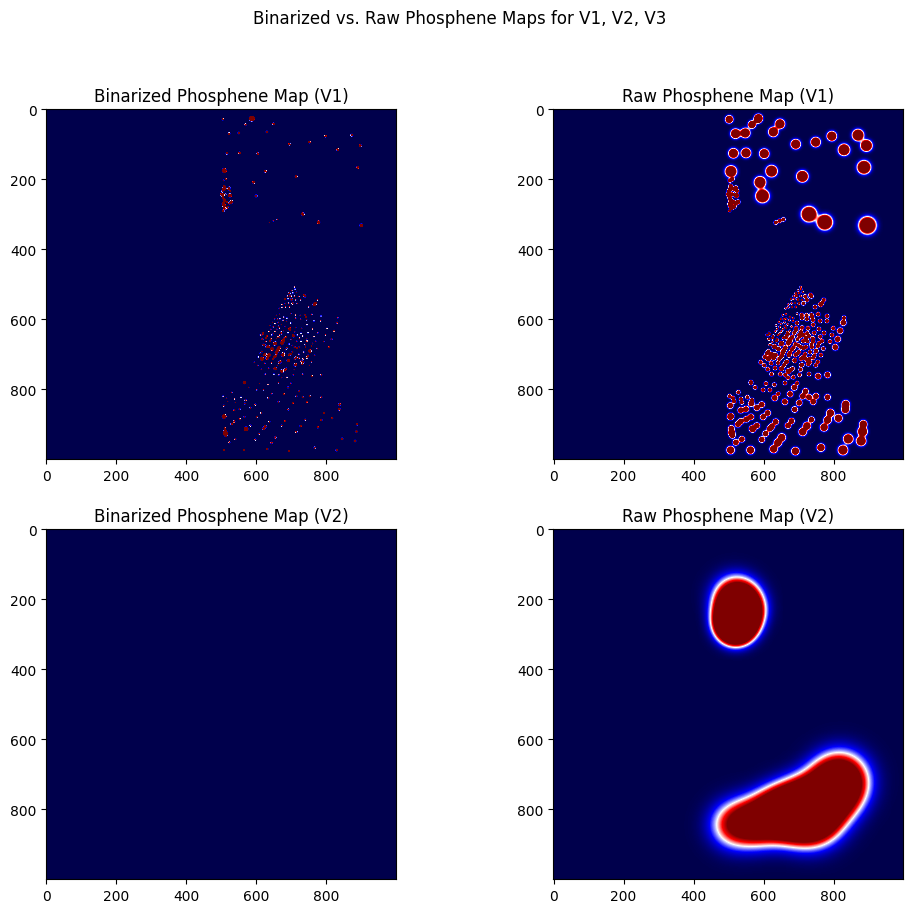

Max phospheneMap (V1): 1.0
Max phospheneMap (V2): 1.0


In [82]:

view_angle  = 90

# Retrieve results from optimization
print('Subject:', s, '| Hemisphere:', hem)
print('Best parameters from optimization:')
print('    Alpha:', res.x[0])
print('    Beta:', res.x[1])
print('    Offset from base:', res.x[2])
print('    Shank length:', res.x[3])

# Run f_manual to get outputs for the optimal parameters
grid_valid, dice, hell_d, grid_yield, phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3, contacts_xyz_moved, phospheneMap = f_manual(
    res.x[0], res.x[1], res.x[2], res.x[3], good_coords, good_coords_V1, good_coords_V2, good_coords_V3, target_density
)

# Print the best metrics
print('Best Dice Coefficient:', dice)
print('Best Yield:', grid_yield)
print('Best Hellinger Distance (KL):', hell_d)
print('Grid Valid:', grid_valid)

# Initialize placeholders for thresholded maps and maps
phosphene_maps = []
phosphene_maps_bin = []

# Loop through each visual area and generate maps
for idx, (phosphenes_area, area_name) in enumerate(
    zip([phosphenes_V1, phosphenes_V2, phosphenes_V3], ['V1', 'V2', 'V3'])
):

    if phosphenes_area.size > 0:
        # Calculate bin threshold
        bin_thresh = np.percentile(phosphenes_area[:, 2], dc_percentile)

        # Generate the phosphene map
        phosphene_map = prf_to_phos(np.zeros((WINDOWSIZE, WINDOWSIZE), 'float32'), phosphenes_area, view_angle=view_angle, phSizeScale=1)
        phosphene_map /= phosphene_map.max()
        
        # Create binarized version
        phosphene_map_bin = (phosphene_map > bin_thresh).astype(bool)
        
        # Store maps for plotting
        phosphene_maps.append((phosphene_map, phosphene_map_bin, area_name))
    else:
        print(f"No valid data points for visual area {area_name}, skipping.")

# Plot each map side-by-side for V1, V2, and V3 if data is available
if phosphene_maps:
    fig, axes = plt.subplots(len(phosphene_maps), 2, figsize=(12, 5 * len(phosphene_maps)))
    fig.suptitle('Binarized vs. Raw Phosphene Maps for V1, V2, V3')

    for i, (phosphene_map, phosphene_map_bin, area_name) in enumerate(phosphene_maps):
        # Binarized map
        axes[i, 0].imshow(phosphene_map_bin, cmap='seismic', vmin=0, vmax=np.max(phosphene_map) /10)
        axes[i, 0].set_title(f'Binarized Phosphene Map ({area_name})')
        axes[i, 0].axis('on')

        # Raw map
        axes[i, 1].imshow(phosphene_map, cmap='seismic', vmin=0, vmax=np.max(phosphene_map) / 10)
        axes[i, 1].set_title(f'Raw Phosphene Map ({area_name})')
        axes[i, 1].axis('on')

    plt.show()
else:
    print("No data available to plot for any visual area.")

# Print maximum values for each map
for phosphene_map, _, area_name in phosphene_maps:
    print(f'Max phospheneMap ({area_name}):', np.max(phosphene_map))


**The following code needs to be checked**

Subject: 100610 | Hemisphere: RH
Best parameters from optimization:
    Alpha: 15
    Beta: 15
    Offset from base: 23
    Shank length: 18
Best Dice Coefficient: 0.46797829763462584
Best Yield: 0.612
Best Hellinger Distance (KL): 0.7686027691613493
Grid Valid: True
No valid data points for visual area V3, skipping.


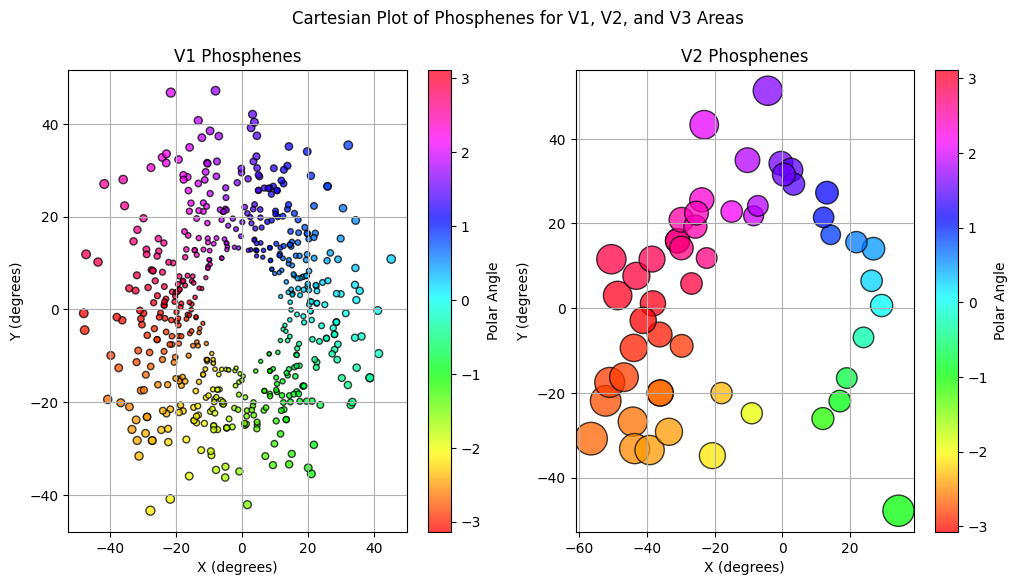

In [78]:
import numpy as np

# Retrieve results from optimization
print('Subject:', s, '| Hemisphere:', hem)
print('Best parameters from optimization:')
print('    Alpha:', res.x[0])
print('    Beta:', res.x[1])
print('    Offset from base:', res.x[2])
print('    Shank length:', res.x[3])

# Run f_manual to get outputs for the optimal parameters
grid_valid, dice, hell_d, grid_yield, phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3, contacts_xyz_moved, phospheneMap = f_manual(
    res.x[0], res.x[1], res.x[2], res.x[3], good_coords, good_coords_V1, good_coords_V2, good_coords_V3, target_density
)

# Print the best metrics
print('Best Dice Coefficient:', dice)
print('Best Yield:', grid_yield)
print('Best Hellinger Distance (KL):', hell_d)
print('Grid Valid:', grid_valid)

# Initialize placeholders for converted Cartesian coordinates data
cartesian_data = []

# Loop through each visual area and prepare data for Cartesian scatter plot
for phosphenes_area, area_name in zip([phosphenes_V1, phosphenes_V2, phosphenes_V3], ['V1', 'V2', 'V3']):
    if phosphenes_area.size > 0:
        # Convert polar coordinates to Cartesian coordinates for plotting
        polar_angles = phosphenes_area[:, 0]
        eccentricities = phosphenes_area[:, 1]
        rf_sizes = phosphenes_area[:, 2]

        x_coords = eccentricities * np.cos(polar_angles)
        y_coords = eccentricities * np.sin(polar_angles)
        
        cartesian_data.append((x_coords, y_coords, rf_sizes, area_name))
    else:
        print(f"No valid data points for visual area {area_name}, skipping.")

# Plot scatter in Cartesian for each area
if cartesian_data:
    fig, axes = plt.subplots(1, len(cartesian_data), figsize=(6 * len(cartesian_data), 6))
    fig.suptitle('Cartesian Plot of Phosphenes for V1, V2, and V3 Areas')

    for i, (x_coords, y_coords, rf_sizes, area_name) in enumerate(cartesian_data):
        ax = axes[i] if len(cartesian_data) > 1 else axes
        scatter = ax.scatter(
            x_coords, y_coords,
            s=rf_sizes * 50, # Scale sizes for better visualization
            c=np.arctan2(y_coords, x_coords), cmap='hsv', alpha=0.75, edgecolor='k'
        )
        ax.set_title(f'{area_name} Phosphenes')
        ax.set_xlabel('X (degrees)')
        ax.set_ylabel('Y (degrees)')
        ax.grid(True)
        fig.colorbar(scatter, ax=ax, orientation='vertical', label='Polar Angle')
    
    plt.show()
else:
    print("No data available to plot for any visual area.")
